In [2]:
from choquet_integral import *
import numpy as np
import cv2
import itertools
import math
import inspect
import matplotlib.pyplot as plt
import csv
import sklearn.metrics as metrics
from scipy.stats import entropy
import random
import xai_indices as xai
import pyemd
from sklearn import datasets
from emd_clustertend import vat, ivat
from sklearn.preprocessing import scale

In [3]:
def random_node_fm(n):
    ch = ChoquetIntegral()
    ch.type='quad'
    ch.fm = {}
    ch.fm[str(np.arange(1,n+1))] = 1
    ch.fm['[]'] = 0
    ch.N = n
    ch.M = n
    numkeys = len(ch.get_keys_index())
    keys = list(ch.get_keys_index().keys())
    keys.append('[]')
    s = [0] * (numkeys + 1)
    s[-1] = 1
    s[-2] = 1
    done = False
    while not done:
        randindex = random.randrange(0,numkeys)
        if s[randindex] == 0:
            s[randindex] = 1
            if keys[randindex] != '[]':
                compare_key = [int(s) for s in keys[randindex][1:-1].split() if s.isdigit()]

            else:
                compare_key = []

            maxi = 0
            max_index = 0
            mini = 1
            min_index = 0
            for i,key in enumerate(keys):
                if s[i] == 1 and i != randindex:
                    if key != '[]':
                        stripped = [int(s) for s in key[1:-1].split() if s.isdigit()]
                    else:
                        stripped = []

                    if is_subset(stripped,compare_key) and s[i] == 1 and ch.fm[key] >= maxi:
                        maxi = ch.fm[key]
                        max_index = i
                    if is_subset(compare_key,stripped) and s[i] == 1 and ch.fm[key] <= mini:

                        mini = ch.fm[key]
                        min_index = i


            rb = ch.fm[keys[max_index]]
            ru = ch.fm[keys[min_index]]
            g = random.uniform(rb,ru)
            ch.fm[keys[randindex]] = g

        else:
            pass
        if min(s) == 1:
            done = True
    return ch

# a is subset of b
def is_subset(a,b):
    if len(a) == 0:
        return True
    if len(b) == 0 and len(a) != 0:
        return False
    for val in a:
        if val not in b:
            return False
    else:
        return True
    
def sample_with_noise(ch,data,mean,var):
    labels = np.zeros(data.shape[0])
    for i,point in enumerate(data):
        labels[i] = max(min(ch.chi_quad(point) + random.gauss(mean,var),1),0)
    return labels

def gen_datapoints(m,n):
    points = []
    for i in range(n):
        point = []
        for j in range(m):
            point.append(random.random())
        points.append(point)
    return np.asarray(points)

def percentage_walks_observed(walks):
    seen = 0
    total = 0
    for key in walks.keys():
        if walks[key] > 0:
            seen = seen + 1
        total = total+1
    return seen/total

def read_crisp(fname):
    part = []
    with open(fname) as csvfile:
        reader = csv.reader(csvfile,delimiter=',')
        for row in reader:
            part.append(row)
    return np.asarray(part,dtype=int)
crisp_part = read_crisp("crisp.csv")

#input: crisp partition matrix, reordering from odm to dm, odm itself
def center_from_crisp(crisp,reordering,odm):
    n = crisp.shape[0]
    row = 0
    num_in_cluster = 0
    cluster_centers = []
    for i in range(n):
        if crisp[row][i] == 1:
            num_in_cluster = num_in_cluster + 1
            
        else:
#             print("new cluster at", i)
            mini = np.inf
            mini_row = row
            for j in range(row,row+num_in_cluster):
                row_sum = np.sum(odm[j][i-num_in_cluster:i])
                if row_sum < mini:
                    mini = row_sum
                    mini_row = j
            cluster_centers.append(reorder[mini_row][0][0])   #the center is row w/ minimum difference, put back in unordered
            row = row+num_in_cluster
            num_in_cluster = 1
            
    mini = np.inf
    mini_row = row
    for j in range(row,row+num_in_cluster):
        row_sum = np.sum(odm[j][i-num_in_cluster+1:i+1])
#         print(row_sum, "sum of row", j)
        if row_sum < mini:
            mini = row_sum
            mini_row = j
    cluster_centers.append(reorder[mini_row][0][0])
    return cluster_centers

def generate_walk_diffs(chi):
    n = chi.M
    initial = []
    for i in range(n):
        initial.append(i+1)

    index_permutations = itertools.permutations(initial,n)
    walks = np.ndarray((math.factorial(n),n),dtype=int)
    walk_diffs = np.ndarray((math.factorial(n),n),dtype=float)
    for i,val in enumerate(index_permutations):
        walks[i] = np.asarray(val)

        c_build = np.ndarray(n)
        for j in range(len(walks[i])):
            if j == 0:
                c_build[j] = chi.fm[str(walks[i][0:1])]
            else:
                c_build[j] = (chi.fm[str(np.sort(walks[i][0:j+1]))]) - (chi.fm[str(np.sort(walks[i][0:j]))])

        walk_diffs[i] = c_build
    return walk_diffs

In [3]:

def gen_seen_walk_diffs(walk_visitation,ch):
    seen_walks = []
    for walk in walk_visitation.keys():
        if walk_visitation[walk] > 0:
            seen_walks.append(walk)
    
    n = len(seen_walks[0])
    walk_diffs = np.ndarray((len(seen_walks),n),dtype=float)
    for i,walk in enumerate(seen_walks):
        walk = list(walk)
        c_build = np.ndarray(n)
        for j in range(len(walk)):
            if j == 0:
                c_build[j] = ch.fm[str(walk[0:1])]
            else:
                c_build[j] = ch.fm[str(np.sort(walk[0:j+1]))] - ch.fm[str(np.sort(walk[0:j]))]
        walk_diffs[i] = c_build
    return walk_diffs
        
    
(walks,_) = xai.walk_visitation(data.T)
seen_diffs = gen_seen_walk_diffs(walks,noisy_split_owa)
all_diffs = noisy_split_owa.generate_walk_diffs()

ivat(all_diffs,figure_size=(5,5),euclidean=True)
ivat(all_diffs,figure_size=(5,5))

NameError: name 'data' is not defined

In [ ]:
custom = ChoquetIntegral()
custom.N = 4
customfm = {}
customfm[str(np.asarray([1]))] = .9
customfm[str(np.asarray([2]))] = 0
customfm[str(np.asarray([3]))] = 0
customfm[str(np.asarray([4]))] = 0
customfm[str(np.asarray([1,2]))] = .9
customfm[str(np.asarray([1,3]))] = .9
customfm[str(np.asarray([1,4]))] = .9
customfm[str(np.asarray([2,3]))] = 0
customfm[str(np.asarray([2,4]))] = 0
customfm[str(np.asarray([3,4]))] = 0
customfm[str(np.asarray([1,2,3]))] = .9
customfm[str(np.asarray([1,2,4]))] = .9
customfm[str(np.asarray([1,3,4]))] = .9
customfm[str(np.asarray([2,3,4]))] = 0
customfm[str(np.asarray([1,2,3,4]))] = 1

custom.fm = customfm
custom.type='quad'
print(custom.fm)


In [ ]:
split_owa = ChoquetIntegral()
split_owa.N = 5
split_fm = {}
split_fm[str(np.asarray([1]))] = .1
split_fm[str(np.asarray([2]))] = .1
split_fm[str(np.asarray([3]))] = .1
split_fm[str(np.asarray([4]))] = .1
split_fm[str(np.asarray([5]))] = .1
split_fm[str(np.asarray([1,2]))] = .2
split_fm[str(np.asarray([1,3]))] = .2
split_fm[str(np.asarray([1,4]))] = .2
split_fm[str(np.asarray([1,5]))] = .2
split_fm[str(np.asarray([2,3]))] = .2
split_fm[str(np.asarray([2,4]))] = .4
split_fm[str(np.asarray([2,5]))] = .4
split_fm[str(np.asarray([3,4]))] = .4
split_fm[str(np.asarray([3,5]))] = .4
split_fm[str(np.asarray([4,5]))] = .4
split_fm[str(np.asarray([1,2,3]))] = .6
split_fm[str(np.asarray([1,2,4]))] = .6
split_fm[str(np.asarray([1,2,5]))] = .6
split_fm[str(np.asarray([1,3,4]))] = .6
split_fm[str(np.asarray([1,3,5]))] = .6
split_fm[str(np.asarray([1,4,5]))] = .6
split_fm[str(np.asarray([2,3,4]))] = .6
split_fm[str(np.asarray([2,3,5]))] = .6
split_fm[str(np.asarray([2,4,5]))] = .6
split_fm[str(np.asarray([3,4,5]))] = .6
split_fm[str(np.asarray([1,2,3,4]))] = .6
split_fm[str(np.asarray([1,2,3,5]))] = .6
split_fm[str(np.asarray([1,2,4,5]))] = .6
split_fm[str(np.asarray([1,3,4,5]))] = .9
split_fm[str(np.asarray([2,3,4,5]))] = .9
split_fm[str(np.asarray([1,2,3,4,5]))] = 1
split_owa.fm = split_fm
split_owa.type ='quad'

In [10]:
max_min = ChoquetIntegral()
max_min.N = 5
max_min.M = 5
max_min_fm = {}
max_min_fm['[]'] = 0
max_min_fm[str(np.asarray([1]))] = .1
max_min_fm[str(np.asarray([2]))] = 0
max_min_fm[str(np.asarray([3]))] = 0
max_min_fm[str(np.asarray([4]))] = 0
max_min_fm[str(np.asarray([5]))] = 0
max_min_fm[str(np.asarray([1,2]))] = .1
max_min_fm[str(np.asarray([1,3]))] = .1
max_min_fm[str(np.asarray([1,4]))] = .1
max_min_fm[str(np.asarray([1,5]))] = .1
max_min_fm[str(np.asarray([2,3]))] = 0
max_min_fm[str(np.asarray([2,4]))] = 0
max_min_fm[str(np.asarray([2,5]))] = 0
max_min_fm[str(np.asarray([3,4]))] = 0
max_min_fm[str(np.asarray([3,5]))] = 0
max_min_fm[str(np.asarray([4,5]))] = 0
max_min_fm[str(np.asarray([1,2,3]))] = .1
max_min_fm[str(np.asarray([1,2,4]))] = .1
max_min_fm[str(np.asarray([1,2,5]))] = .1
max_min_fm[str(np.asarray([1,3,4]))] = .1
max_min_fm[str(np.asarray([1,3,5]))] = .1
max_min_fm[str(np.asarray([1,4,5]))] = .1
max_min_fm[str(np.asarray([2,3,4]))] = 0
max_min_fm[str(np.asarray([2,3,5]))] = 0
max_min_fm[str(np.asarray([2,4,5]))] = 0
max_min_fm[str(np.asarray([3,4,5]))] = 0
max_min_fm[str(np.asarray([1,2,3,4]))] = .1
max_min_fm[str(np.asarray([1,2,3,5]))] = .1
max_min_fm[str(np.asarray([1,2,4,5]))] = .1
max_min_fm[str(np.asarray([1,3,4,5]))] = .1
max_min_fm[str(np.asarray([2,3,4,5]))] = 0
max_min_fm[str(np.asarray([1,2,3,4,5]))] = 1
max_min.fm = max_min_fm
max_min.type ='quad'

[[0.  0.  0.  ... 0.4 0.3 0.4]
 [0.  0.  0.  ... 0.4 0.3 0.4]
 [0.  0.  0.  ... 0.4 0.3 0.4]
 ...
 [0.4 0.4 0.4 ... 0.  0.1 0. ]
 [0.3 0.3 0.3 ... 0.1 0.  0.1]
 [0.4 0.4 0.4 ... 0.  0.1 0. ]]
did this
[[0.         0.         0.         ... 0.14142136 0.14142136 0.14142136]
 [0.         0.         0.         ... 0.14142136 0.14142136 0.14142136]
 [0.         0.         0.         ... 0.14142136 0.14142136 0.14142136]
 ...
 [0.14142136 0.14142136 0.14142136 ... 0.         0.14142136 0.        ]
 [0.14142136 0.14142136 0.14142136 ... 0.14142136 0.         0.14142136]
 [0.14142136 0.14142136 0.14142136 ... 0.         0.14142136 0.        ]]


IndexError: index 0 is out of bounds for axis 0 with size 0

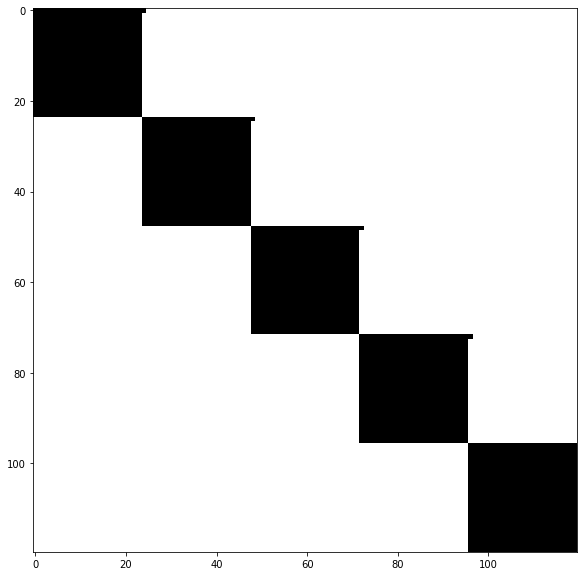

In [11]:
max_min.fm
max_min_diffs = max_min.generate_walk_diffs()
ivat(max_min_diffs)
ivat(max_min_diffs,euclidean=True)

In [ ]:
data = gen_datapoints(5,30)
noisy_labels = sample_with_noise(split_owa,data,0,0)

noisy_split_owa = ChoquetIntegral()
noisy_split_owa.train_chi(data.T,noisy_labels)

(walks,_) = xai.walk_visitation(data.T)
# print(walks)
print(percentage_walks_observed(walks))

owa_diffs = split_owa.generate_walk_diffs()
ivat(owa_diffs,figure_size=(5,5))
noisy_owa_diffs = noisy_split_owa.generate_walk_diffs()
ivat(noisy_owa_diffs,figure_size=(5,5))

In [ ]:
data = gen_datapoints(4,200)
noisy_labels = sample_with_noise(split_owa,data,0,0)

noisy_chi = ChoquetIntegral()
noisy_chi.train_chi(data.T,noisy_labels)

xai.walk_visitation(data.T)

In [ ]:
(walks,_) = xai.walk_visitation(data.T)


percentage_walks_observed(walks)
# print(walks.keys())

[[0.         0.10942393 0.78595322 0.76491634 0.68962985 0.60758512
  0.22773971 0.25266376 0.26884282 0.30942471 0.95088655 0.95775642
  0.87130593 0.85237818 0.19473262 0.24776598 0.71531226 0.7952543
  0.61573158 0.52220276 0.73014786 0.7390724  0.53696104 0.63959748]
 [0.10942393 0.         0.73735607 0.7215895  0.62837597 0.56744761
  0.25266376 0.22773971 0.27698186 0.27084396 0.89925918 0.90492912
  0.82773518 0.81372167 0.20582343 0.19748617 0.68010349 0.73949034
  0.54625306 0.47490297 0.6615117  0.66919905 0.48907698 0.56877192]
 [0.78595322 0.73735607 0.         0.04397066 0.13986231 0.18355594
  0.70042493 0.6454197  0.63468073 0.57439774 0.23826681 0.24399024
  0.15097391 0.15724675 0.65482692 0.59658313 0.17110152 0.13827714
  0.45532048 0.47058268 0.38589342 0.38945332 0.45695616 0.44570592]
 [0.76491634 0.7215895  0.04397066 0.         0.15552811 0.15757725
  0.67673453 0.62734681 0.61091772 0.55777663 0.25949922 0.26694251
  0.15724675 0.15097391 0.63182206 0.58059748 

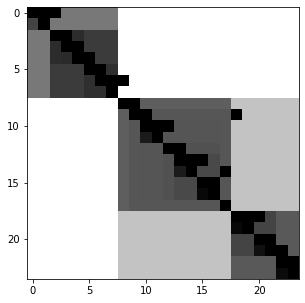

In [10]:

ch = random_node_fm(4)

diffs = ch.generate_walk_diffs()
odm = ivat(diffs,return_odm=True,figure_size=(5,5),euclidean=True)
# odm,reorder = ivat(diffs,return_odm=True,euclidean=True)

In [ ]:

print(center_from_crisp(crisp_part,reorder,odm))
ch.generate_walk_diffs()

In [ ]:
with open('odm.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in odm:
        writer.writerow(row)